In [145]:
%pylab notebook
import os, sys, importlib
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import pandas as pd, hts_fitting as hts, default_figure_style as dfs, hts_dosecalculations as dose
for library in [hts, dfs, dose]:
    importlib.reload(library)
    
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

parentDirectory = '../data/srim/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


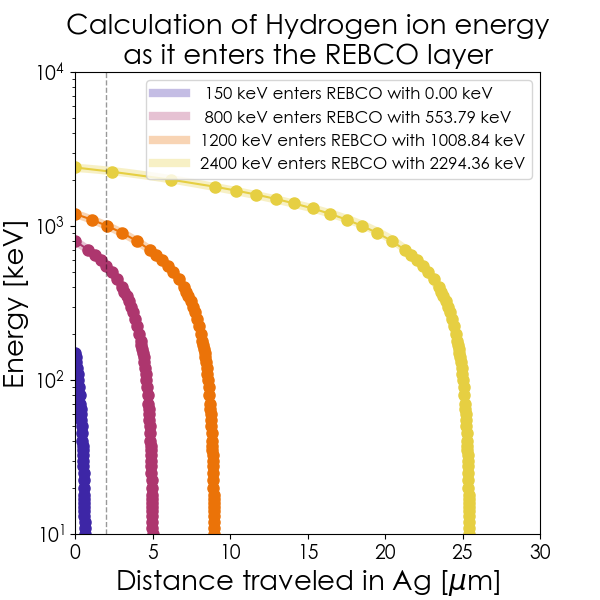

In [4]:
ffunction = hts.poly5

fpaths = [
    parentDirectory+'AgTarget_0150keVH.txt',
    parentDirectory+'AgTarget_0800keVH.txt',
    parentDirectory+'AgTarget_1200keVH.txt',
    parentDirectory+'AgTarget_2400keVH.txt'
]
nrows = [32, 51, 55, 64]

fig, ax = plt.subplots()
for fpath, nr in zip(fpaths, nrows):
    data = pd.read_csv(fpath, skiprows=23, nrows=nr, usecols=[0, 1, 4, 5], names=['energy_keV', 'energy_units', 'range_A', 'range_units'], delim_whitespace=True)
    data.loc[data.range_units == 'A', 'range_A'] *= 1e-4
    data.loc[data.energy_units == 'MeV', 'energy_keV'] *= 1e3
    x, y = -1*(data.range_A-data.range_A.max()), data.energy_keV
    popt, pcov = curve_fit(ffunction, x, y)
    xsmooth = np.linspace(x.min(), x.max(), 10000)
    ysmooth = ffunction(xsmooth, *popt)
    e0 = y.iloc[-1]
    if e0 != 150:
        e0REBCO = ysmooth[np.argmin(np.abs(xsmooth-2))]
    else:
        e0REBCO = 0
    ax.semilogy(x, y, marker='o', color=dfs.colors_energy[str(int(e0))])
    ax.semilogy(xsmooth, ysmooth, color=dfs.colors_energy[str(int(e0))], linewidth=6, alpha=.3, label='{:4.0f} keV enters REBCO with {:<4.2f} keV'.format(e0, e0REBCO))
        
ax.axvline(2, linestyle='--', color='k', linewidth=1, alpha=.4)
ax.set_xlabel('Distance traveled in Ag [$\mu$m]')
ax.set_ylabel('Energy [keV]')
ax.set_title('Calculation of Hydrogen ion energy\nas it enters the REBCO layer')
ax.set_ylim(1e1, 1e4)
ax.set_xlim(0, 30)
ax.legend()

<IPython.core.display.Javascript object>


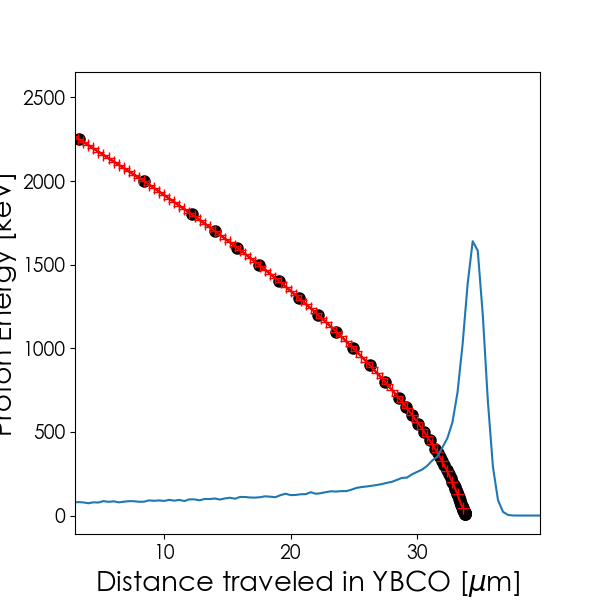

<IPython.core.display.Javascript object>


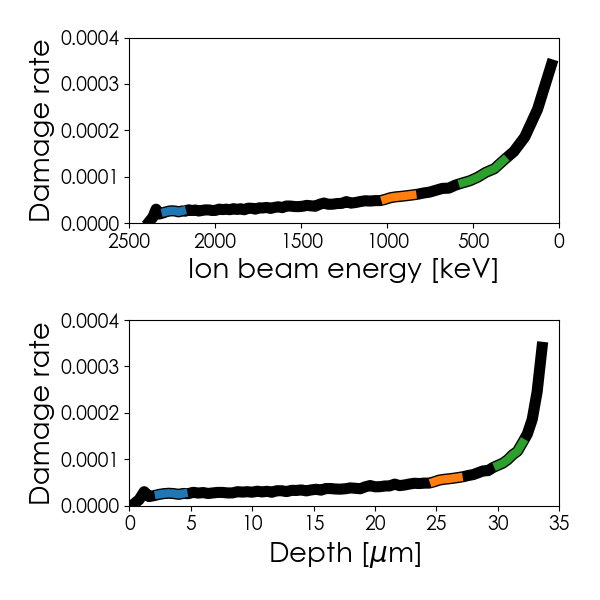

In [161]:
datafp = pd.read_csv('../data/srim/2024-05-04_22-17-58_YBCO_H_2400keV_1000000ions_KP/2024-05-05-02-57-59-902061-1000000H-2400keV-1.txt', delim_whitespace=True, usecols=[0, 3], names=['depth', 'fp'], skiprows=1)
datafp['depth'] *= 1e-4

data = pd.read_csv('../data/srim/Y1Ba2Cu3O7_2400keVH.txt', skiprows=26, nrows=64, usecols=[0, 1, 4, 5, 6, 7], names=['energy', 'energy_units', 'depth', 'range_units', 'straggle', 'straggle_units'], delim_whitespace=True)
data.loc[data.range_units == 'A', 'depth'] *= 1e-4
data.loc[data.energy_units == 'MeV', 'energy'] *= 1e3

x, y = data.depth.max()-data.depth, data.energy
interpolation = interp1d(x, y)

xfp = datafp.depth
cut = (np.min(x) <= xfp) & (xfp <= np.max(x))
interpolated_energy = interpolation(xfp[cut])


fig, ax = plt.subplots(1, 1, sharex=True)
ax.plot(x, y, marker='o', color='k')
ax.plot(datafp.depth[cut], interpolated_energy, color='r', marker='+')
ax.plot(datafp.depth, datafp.fp*3000000)
ax.set_ylabel('Proton Energy [keV]')
ax.set_xlabel('Distance traveled in YBCO [$\mu$m]')
ax.set_xlim(0, 35)
ax.set_ylim(0, 2500)


fig, ax = plt.subplots(2, 1)
ax[0].plot(interpolated_energy, datafp.fp[cut], color='k', linewidth=8)
ax[1].plot(datafp.depth[cut], datafp.fp[cut], color='k', linewidth=8)

zmin2400keV = datafp.depth[np.argmin(np.abs(2294.36-interpolated_energy))]
cut2400keV = (zmin2400keV <= datafp.depth[cut]) & (datafp.depth[cut] <= zmin2400keV+2)
ax[0].plot(interpolated_energy[cut2400keV], datafp.fp[cut][cut2400keV], linewidth=6)
ax[1].plot(datafp.depth[cut][cut2400keV], datafp.fp[cut][cut2400keV], linewidth=6)
profile2400keV = datafp[cut][cut2400keV]

zmin1200keV = datafp.depth[np.argmin(np.abs(1008.8-interpolated_energy))]
cut1200keV = (zmin1200keV <= datafp.depth[cut]) & (datafp.depth[cut] <= zmin1200keV+2)
ax[0].plot(interpolated_energy[cut1200keV], datafp.fp[cut][cut1200keV], linewidth=6)
ax[1].plot(datafp.depth[cut][cut1200keV], datafp.fp[cut][cut1200keV], linewidth=6)
profile1200keV = datafp[cut][cut1200keV]

zmin800keV = datafp.depth[np.argmin(np.abs(553.79-interpolated_energy))]
cut800keV = (zmin800keV <= datafp.depth[cut]) & (datafp.depth[cut] <= zmin800keV+2)
ax[0].plot(interpolated_energy[cut800keV], datafp.fp[cut][cut800keV], linewidth=6)
ax[1].plot(datafp.depth[cut][cut800keV], datafp.fp[cut][cut800keV], linewidth=6)
profile0800keV = datafp[cut][cut800keV]


ax[0].set_xlim(2500, 0)
ax[0].set_ylim(0, 0.0004)
ax[1].set_xlim(0, 35)
ax[1].set_ylim(0, 0.0004)
ax[0].set_xlabel('Ion beam energy [keV]')
ax[0].set_ylabel('Damage rate')
ax[1].set_xlabel('Depth [$\mu$m]')
ax[1].set_ylabel('Damage rate')

fig.tight_layout()


<IPython.core.display.Javascript object>


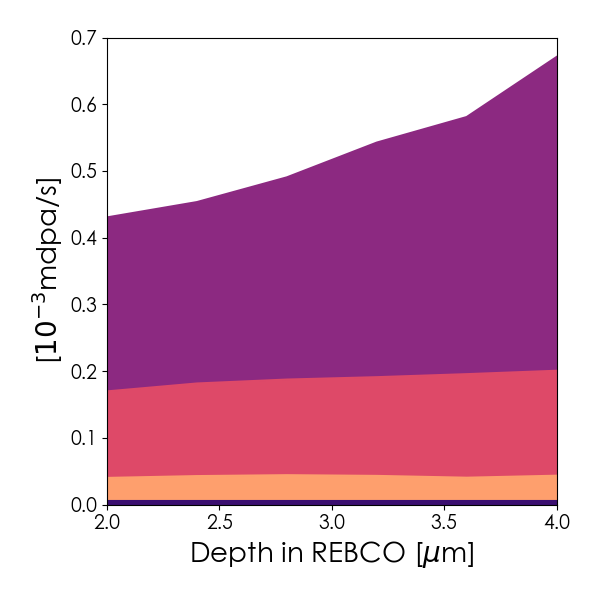

12.453497709306852 0.5280877552500001
4.427046491778315 0.18772790575000003
1.0 0.04240477395000001


In [202]:
fig, ax = plt.subplots()
for profile, ibeam, c in zip([profile0800keV, profile1200keV, profile2400keV], [45, 30, 15], dfs.palette[1:]):
    x, y = profile.depth-profile.depth.min()+2, 1e3*1.43*profile.fp*ibeam/13
    print(profile.fp.mean()*ibeam/(profile2400keV.fp.mean()*15), 1e3*1.43*profile.fp.mean()*ibeam/13)
    ax.fill_between(x, 0, y, color=c, alpha=1.)
    ax.plot(x, y, color=c, alpha=1)

'''
ftapes = [
    '2024-05-01_12-11-08_FFJ_H_0150keV_1000000ions_KP/2024-05-01-14-40-06-478348-1000000H-150keV-1.txt',
    '2024-05-01_14-40-06_FFJ_H_0800keV_1000000ions_KP/2024-05-01-20-16-22-711934-1000000H-800keV-1.txt',
    '2024-05-01_20-16-22_FFJ_H_1200keV_1000000ions_KP/2024-05-02-02-16-56-352416-1000000H-1200keV-1.txt',
    '2024-05-02_02-16-56_FFJ_H_2400keV_1000000ions_KP/2024-05-02-09-04-50-844585-1000000H-2400keV-1.txt'
]

for ftape, ibeam, c in zip(ftapes, [240, 45, 30, 15], dfs.palette):
    data = pd.read_csv('../data/srim/'+ftape, delim_whitespace=True, usecols=[0, 3], names=['depth', 'fp'], skiprows=1)
    data['depth'] *= 1e-4
    cut = (2 <= data.depth) & (data.depth <= 4)
    ax.plot(data.depth, 1.43*ibeam*data.fp, color='k', linestyle='--')
'''      

ax.axhline(0, linewidth=8, color=dfs.palette[0])
ax.set_xlim(2, 4)
ax.set_ylim(0, 0.7)
ax.set_xlabel('Depth in REBCO [$\mu$m]')
ax.set_ylabel('[$10^{-3}$mdpa/s]')
#ax.set_title('(b) Damage rate at $\mathrm{P_{beam} = 36\, mW}$')
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'damagerate-b.svg')

12.453497709306854

<IPython.core.display.Javascript object>


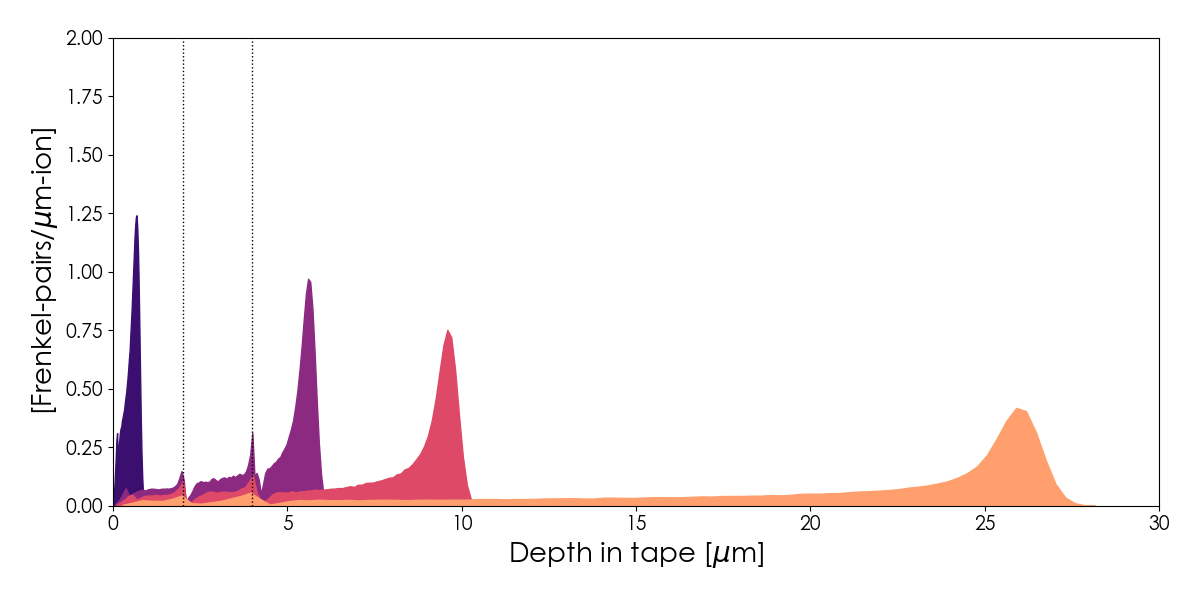

In [190]:
fig, ax = plt.subplots(figsize=(12,6))

ftapes = [
    '2024-05-01_12-11-08_FFJ_H_0150keV_1000000ions_KP/2024-05-01-14-40-06-478348-1000000H-150keV-1.txt',
    '2024-05-01_14-40-06_FFJ_H_0800keV_1000000ions_KP/2024-05-01-20-16-22-711934-1000000H-800keV-1.txt',
    '2024-05-01_20-16-22_FFJ_H_1200keV_1000000ions_KP/2024-05-02-02-16-56-352416-1000000H-1200keV-1.txt',
    '2024-05-02_02-16-56_FFJ_H_2400keV_1000000ions_KP/2024-05-02-09-04-50-844585-1000000H-2400keV-1.txt'
]

for ftape, ibeam, c in zip(ftapes, [240, 45, 30, 15], dfs.palette):
    data = pd.read_csv('../data/srim/'+ftape, delim_whitespace=True, usecols=[0, 3], names=['depth', 'fp'], skiprows=1)
    data['depth'] *= 1e-4
    cut = (2 <= data.depth) & (data.depth <= 4)
    #ax.plot(data.depth, data.fp, color=c)
    ax.fill_between(data.depth, 0, 1e3*data.fp, color=c, alpha=1.)
    
ax.axvline(2, linestyle=':', linewidth=1, color='k')
ax.axvline(4, linestyle=':', linewidth=1, color='k')
ax.set_xlim(0, 30)
ax.set_ylim(0, 2)
ax.set_xlabel('Depth in tape [$\mu$m]')
ax.set_ylabel('[Frenkel-pairs/$\mu$m-ion]')
#ax.set_title('(a) Kinchin-Pease damage profile')
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'damagerate-a.svg')

In [194]:
from scipy import constants as cst

In [199]:
ibeam = 1e-9
area = np.pi*(3.125e-3/2)**2

flux = 90*ibeam/(area*cst.elementary_charge)

print('{:4.2e}'.format(flux))

7.32e+16


In [195]:
cst

<module 'scipy.constants' from '/Users/alexisdevitre/anaconda3/lib/python3.11/site-packages/scipy/constants/__init__.py'>